## Yeast cell in microstructures

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchvision
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms

In [2]:
# ! wget https://tudatalib.ulb.tu-darmstadt.de/bitstream/handle/tudatalib/3799/yeast_cell_in_microstructures_dataset.zip
# ! unzip yeast_cell_in_microstructures_dataset.zip -d yeast_cell_in_microstructures_dataset

Посмотрим на структуру данных:

In [3]:
! tree -P '?.pt' yeast_cell_in_microstructures_dataset/train

yeast_cell_in_microstructures_dataset/train
├── bounding_boxes
│   ├── 0.pt
│   ├── 4.pt
│   ├── 5.pt
│   └── 8.pt
├── classes
│   ├── 0.pt
│   ├── 4.pt
│   ├── 5.pt
│   └── 8.pt
├── inputs
│   ├── 0.pt
│   ├── 4.pt
│   ├── 5.pt
│   └── 8.pt
└── instances
    ├── 0.pt
    ├── 4.pt
    ├── 5.pt
    └── 8.pt

4 directories, 16 files


In [4]:
dataset_dir = Path("yeast_cell_in_microstructures_dataset")
train_dir = dataset_dir / "train"
fname = "5.pt"

for subdir in train_dir.glob("*"):
    print(f"{subdir.stem} shape: ", torch.load(subdir / fname, weights_only=True).shape)

bounding_boxes shape:  torch.Size([2, 4])
classes shape:  torch.Size([2])
instances shape:  torch.Size([2, 256, 256])
inputs shape:  torch.Size([256, 256])


Визуализируем один пример:

In [5]:
def masks_to_rgb(masks: Tensor) -> Tensor:
    """
    Преобразует тензор с бинарными масками произвольного кол-ва объектов (до 9)
    в тензор с тремя каналами, который можно конвертировать в RGB изображение

    Args:
        masks (Tensor): тензор с бинарными масками N отдельных объектов размера N x W x H
    """
    _colors = torch.tensor([
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0],
        [0.5, 0.0, 0.5],
        [0.5, 0.5, 0.0],
        [0.0, 0.5, 0.5],
        [0.5, 0.3, 0.2],
        [0.2, 0.3, 0.5],
        [0.2, 0.5, 0.3],
    ])[:len(masks)]
    return (masks.unsqueeze(0) * _colors.T.unsqueeze(-1).unsqueeze(-1)).sum(dim=1)

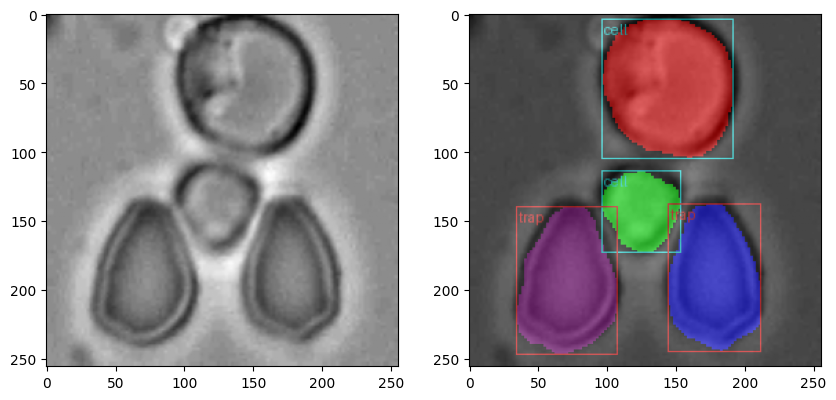

In [6]:
fname = "4.pt"
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(torch.load(train_dir / "inputs" / fname, weights_only=True), cmap="gray")
ax[1].imshow(torch.load(train_dir / "inputs" / fname, weights_only=True), cmap="gray")


colordict = {0: "red", 1: "cyan"}
class_names = {0: "trap", 1: "cell"}

classes = torch.load(train_dir / "classes" / fname, weights_only=True)

annot = torchvision.utils.draw_bounding_boxes(
    transforms.ConvertImageDtype(torch.uint8)(
        masks_to_rgb(torch.load(train_dir / "instances" / fname, weights_only=True))
    ),
    boxes=torch.load(train_dir / "bounding_boxes" / fname, weights_only=True),
    colors=[colordict[i] for i in classes.tolist()],
    labels=[class_names[i] for i in classes.tolist()],
)

ax[1].imshow(transforms.ToPILImage()(annot), alpha=0.5)

#### Реализация `Dataset`

Сначала реализуем более общий случай: датасет для instance segmentation. Из него легко будет получить датасеты для semantic segmentation и object detection

In [7]:
class YeastDataset(Dataset):
    def __init__(self, subset_dir: Path) -> None:
        super().__init__()
        self.subset_dir = subset_dir
        self.items = list((self.subset_dir / "inputs").glob("*.pt"))

    def __getitem__(self, index: int) -> tuple[Tensor, dict[str, Tensor]]:
        # нужно вернуть пару
        # тензор изображения C x W x H
        # словарь с ключами boxes, masks, labels
        image_path = self.items[index]
        image = torch.load(image_path, weights_only=True).unsqueeze(0)  # (W, H) -> (1, W, H)
        # 0 класс - фон
        classes = torch.load(self.subset_dir / "classes" / image_path.parts[-1], weights_only=True) + 1
        masks = torch.load(self.subset_dir / "instances" / image_path.parts[-1], weights_only=True)
        boxes = torch.load(self.subset_dir / "bounding_boxes" / image_path.parts[-1], weights_only=True)
        return image, dict(
            boxes=boxes,
            labels=classes,
            masks=masks,
        )

    def __len__(self) -> int:
        return len(self.items)

Проверим, что всё отрисовывается корректно:

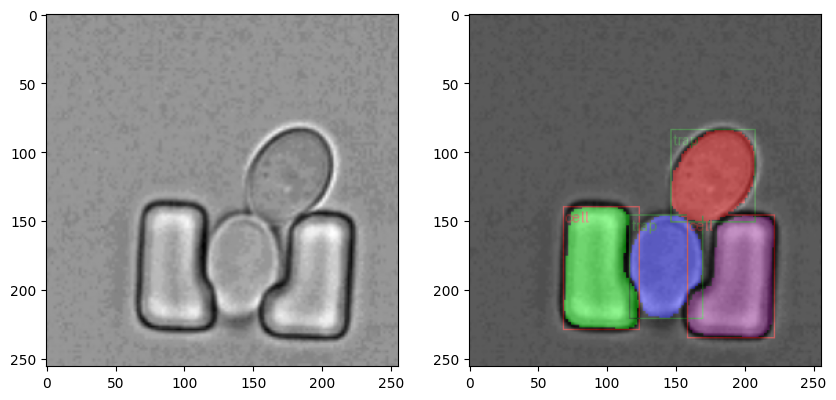

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

train_dataset = YeastDataset(train_dir)

x, target = train_dataset[5]
ax[0].imshow(x[0], cmap="gray")
ax[1].imshow(x[0], cmap="gray")


colordict = {1: "red", 2: "green"}
class_names = {1: "cell", 2: "trap"}

annot = torchvision.utils.draw_bounding_boxes(
    transforms.ConvertImageDtype(torch.uint8)(masks_to_rgb(target["masks"])),
    boxes=target["boxes"],
    colors=[colordict[i.item()] for i in target["labels"]],
    labels=[class_names[i.item()] for i in target["labels"]],
)
ax[1].imshow(transforms.ToPILImage()(annot), alpha=0.4)